In [102]:
# data exploration
%reload_ext autoreload
%autoreload 2

In [94]:
import os
import spacy
import pandas as pd
import json
from tqdm import tqdm

import data_preprocess as dataproc
import analyze_tools
import extract_and_normalize
import feature_and_labels
import train_and_inference

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow.keras as keras
import numpy as np

import warnings
warnings.filterwarnings('ignore')



DATA_FOLDER = '/home/vishal/Documents/_practice/zycus-ml-test/data/'
TRAINING_FOLDER = os.path.join(DATA_FOLDER, 'Training_data')
VALIDATION_FOLDER = os.path.join(DATA_FOLDER, 'Validation_Data')

TRAINING_CSV_PATH = os.path.join(DATA_FOLDER, 'TrainingTestSet.csv')
VALIDATION_CSV_PATH = os.path.join(DATA_FOLDER, 'ValidationSet.csv')

In [3]:
pd.reset_option('all')
pd.set_option('display.max_colwidth', 1000)


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



/home/vishal/Documents/Projects/my_env2/lib/python3.6/site-packages/pandas/_config/config.py:622: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


### Open docs and align them them against target

In [4]:
training_files_path_list = [i for i in dataproc.get_files_path(TRAINING_FOLDER)]
train_label_csv = pd.read_csv(TRAINING_CSV_PATH)

training_file_names = list(map(lambda s:s.split('/')[-1].split('.')[0], training_files_path_list))
training_file_names = dict(list(zip(training_file_names, training_files_path_list)))

# # sanity check: whether file names match?
# training_files_in_folder = set(training_file_names.keys())
# training_files_in_csv = set(train_label_csv['File Name'].values)
# len(training_files_in_folder), len(training_files_in_csv), len(training_file_in_folder.intersection(training_files_in_csv))

In [5]:
combined_csv = train_label_csv.copy()
combined_csv = combined_csv[combined_csv['File Name'].isin(training_file_names)]
combined_csv['filepath'] = combined_csv['File Name'].apply(lambda x: training_file_names[x])
combined_csv['full_text'] = combined_csv.filepath.apply(lambda x: dataproc.get_full_text(x))
combined_csv['text'] = combined_csv.full_text.apply(lambda x: dataproc.clean_text(x))

### Seeing few of the documents

In [6]:
doc_index = 27 # change between 1-43
print('Path:', combined_csv.filepath.values[doc_index])
target_labels = dict(combined_csv.iloc[doc_index, :-2])
print(json.dumps(target_labels, indent=2))
full_text = combined_csv.text.values[doc_index]
analyze_tools.visualize_spacy_ents(full_text);

Path: /home/vishal/Documents/_practice/zycus-ml-test/data/Training_data/203615996-Rental-Agreement-Format.pdf.docx
{
  "File Name": "203615996-Rental-Agreement-Format",
  "Aggrement Value": 3500.0,
  "Aggrement Start Date": "01.02.2008",
  "Aggrement End Date": "31.01.2009",
  "Renewal Notice (Days)": 30.0,
  "Party One": " T.RADHA KRISHNAN ",
  "Party Two": "ABHIJIT BHARADWAJ ",
  "filepath": "/home/vishal/Documents/_practice/zycus-ml-test/data/Training_data/203615996-Rental-Agreement-Format.pdf.docx"
}


### Analysizing patterns
Important for tagging training datasets

In [8]:
all_text_concatenated_cleaned = '\n\n'.join(combined_csv.text.values)
split_paragraphs_all_cleaned = all_text_concatenated_cleaned.split('\n\n')

nlp = spacy.load('en')
spacy_docs = []
for i in tqdm(split_paragraphs_all_cleaned):
    spacy_docs.append(nlp(i))
all_ents = [(ent, ind, ent.label_) for ind, i in enumerate(spacy_docs) for ent in i.ents]
groups = analyze_tools.group_by_labels(all_ents)

{i:j for i, j in groups.items() if i in ['PERSON', 'PRODUCT']} # first item is extracted text, second is paragraph number

print('See date patterns')
{i:j for i, j in groups.items() if i in ['DATE']} # first item is extracted text, second is paragraph number

In [24]:
print('Targets') ## seeing target format
combined_csv.iloc[:30, 1:-3]

Targets


,Aggrement Value,Aggrement Start Date,Aggrement End Date,Renewal Notice (Days),Party One,Party Two
8,6500.0,20.05.2007,20.05.2008,15.0,"Antonio Levy S. Ingles, Jr. and/or Mary Rose C. Ingles",GERALDINE Q. GALINATO
9,6500.0,20.05.2007,20.05.2008,15.0,"Antonio Levy S. Ingles, Jr. and/or Mary Rose C. Ingles",GERALDINE Q. GALINATO
10,4000.0,05.12.2008,31.11.2009,90.0,MR.K.Kuttan,P.M. Narayana Namboodri
12,3800.0,01.05.2010,31.04.2011,30.0,Balaji.R,Kartheek R
13,3000.0,20.09.2010,19.07.2011,NaN,M.V.V. VIJAYA SHANKAR,MADDIREDDY BHARGAVA REDDY
14,700.0,15.12.2008,NaN,NaN,"PROSPER 4 LESS,LLC",Jose Luis Salcido
15,9000.0,01.04.2010,31.02.2011,60.0,P C MATHEW,L GOPINATH
16,10000.0,01.04.2010,30.03.2011,90.0,P. JohnsonRavikumar,Saravanan BV
17,8000.0,01.04.2011,31.03.2012,90.0,K. Parthasarathy,Veerabrahmam Bathini
18,5500.0,21.04.2011,19.02.2012,60.0,Asha Ramesh & Ramesh K.N,Sadasivuni Deepthi & Sadasivuni Kiran


### Extract patterns

In [84]:
one_doc_full_text = combined_csv.text[27]

print(one_doc_full_text)

RENTAL AGREEMENT This Rental Agreement is made and executed at Bangalore on this the 1st May 2005 by and between:

Mrs. S.Sakunthala, Hno: 4E,10-12-1, REDNAM ALCAZAR, Opp. SBI Main, Old Jail Road Jn, Vishakapatnam - 530020 Hereinafter called as the LESSOR (which expression shall mean and include wherever the context so requires admits his heirs, executors, representatives and assigns) of the ONE PART

And: V.V.Ravi Kian S/o V.R.G.Sastry, A.S.Rao Nagar, Hyderabad Andhra Pradesh.-36 Hereinafter called the LESSEE (Which expression shall mean and include wherever the context so requires, admits his executors, representatives and assigns) of the OTHER PART.

WITNESSES AS FOLLOWS: Whereas the Lessor is the absolute owner of the Fourth Floor residential premises bearing No:407A, T.C.Palya Main Road, Ram murthy nagar, Bangalore-16, which are morefully described in the Schedule written here under and hereinafter referred to as the Schedule Property.

Whereas the Lessor has agreed to grant a lea

In [89]:
candidates = extract_and_normalize.extract_candidates(one_doc_full_text)

candidates

{'date': [['1st may 2005', (85, 97), [1, 5, 2005]],
  ['1st april 2010', (1177, 1191), [1, 4, 2010]],
  ['10-12-1', (142, 149), [10, 12, 1]]],
 'duration': [['11 (eleven) month', (1142, 1159), 330],
  ['one month', (2530, 2539), 30],
  ['three month', (2754, 2765), 90]],
 'amount': [['1', (85, 86), 1],
  ['2005', (93, 97), 2005],
  ['4E,10-12-1', (139, 149), 'NA'],
  ['530020', (216, 222), 530020],
  ['ONE', (395, 398), 1],
  ['36', (483, 485), 36],
  ['Four', (732, 736), 4],
  ['407', (777, 780), 407],
  ['16', (832, 834), 16],
  ['11 (Eleven', (1142, 1152), 11],
  ['1', (1177, 1178), 1],
  ['2010', (1187, 1191), 2010],
  ['5', (1324, 1325), 5],
  ['9,000', (1446, 1451), 9000],
  ['Nine thousand', (1455, 1468), 9000],
  ['two hundred', (1473, 1484), 200],
  ['80,000', (2281, 2287), 80000],
  ['Eighty thousand', (2295, 2310), 80000],
  ['one', (2530, 2533), 1],
  ['three', (2754, 2759), 3],
  ['Four', (2896, 2900), 4],
  ['407', (2953, 2956), 407],
  ['560037', (3010, 3016), 560037],
 

### Due to deadline (and my office work) I couldn't finish this.
Following steps should be followed to get atleast first iteration result.

**Option1 training deep NN: more data is required for this**
* get all for each text, find exact text span (strat char, end char) and label them in NER style, i.e.`B-AMOUNT, I, I, O, B-PARTY_ONE` etc
to do this we would need extract.py, handle_datetime.py and normalize_date, normalize_amount map_name etc

* once this is done a seq-to-seq model (many to many) with return sequence true, model can be trained (transformer or bi-lstm based)
* predict on test set texts, and use the same function from utilities to map them back to result format

**Option2 feature engineer: may work in low resource setting**
* extract all candidates with regex and/or spacy, along with their features such as context, shape, vector, label
* train a traditional ml model (random forest, l

### ITERATION 2: Continuing option 2

In [90]:
flattened_candidates = feature_and_labels.get_candidates_features_and_labels_all_together(combined_csv)

Extracting...: 100%|██████████| 43/43 [00:22<00:00,  1.87it/s]
Labeling...: 43it [00:00, 1340.79it/s]
Featuring...: 43it [00:26,  1.59it/s]


In [97]:
vector_to_labels = train_and_inference.label_encode(flattened_candidates)
train_candidates, test_candidates = train_test_split(flattened_candidates)
train_X, train_y = get_x_and_y(train_candidates)

model = train_and_inference.define_dense_model()

In [98]:
history = model.fit(x=train_X, y=train_y, batch_size=100, epochs=100, validation_split=0.1)

Train on 3066 samples, validate on 341 samples
Epoch 1/100
3066/3066 [==============================] - 0s 133us/sample - loss: 2.5980 - accuracy: 0.1416 - val_loss: 2.8184 - val_accuracy: 0.1613
Epoch 2/100
3066/3066 [==============================] - 0s 19us/sample - loss: 1.9865 - accuracy: 0.3229 - val_loss: 1.9749 - val_accuracy: 0.4311
Epoch 3/100
3066/3066 [==============================] - 0s 20us/sample - loss: 1.5987 - accuracy: 0.5085 - val_loss: 1.4743 - val_accuracy: 0.6188
Epoch 4/100
3066/3066 [==============================] - 0s 18us/sample - loss: 1.3212 - accuracy: 0.6455 - val_loss: 1.1765 - val_accuracy: 0.7126
Epoch 5/100
3066/3066 [==============================] - 0s 18us/sample - loss: 1.1471 - accuracy: 0.7065 - val_loss: 1.0022 - val_accuracy: 0.7566
Epoch 6/100
3066/3066 [==============================] - 0s 18us/sample - loss: 1.0241 - accuracy: 0.7404 - val_loss: 0.8892 - val_accuracy: 0.7889
Epoch 7/100
3066/3066 [==============================] - 0s 19us

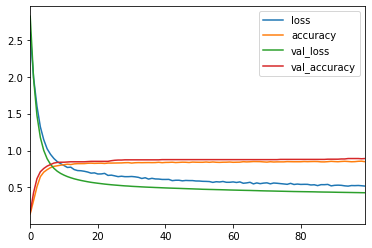

In [99]:
history_df = pd.DataFrame(history.history)
history_df.plot();

In [117]:
candidate = test_candidates[4]
train_and_inference.inference_on_example(candidate, model, vector_to_labels, threshold=0.3, show=True)

Candidate Info:
	text: ('Tenant', (708, 714), 'Tenant')
	type: names
	meta: {'text_no': 24}

Result:
	true_label: NAME_FALSE
	predicted_labels: ['NAME_FALSE']


array(['NAME_FALSE'], dtype='<U17')

In [118]:
# inference on all true candidates 
true_test_candidates = [candidate for candidate in test_candidates if not candidate['label'].endswith('FALSE')]

In [120]:
for i, candidate in enumerate(true_test_candidates):
    print(i, end=' ')
    train_and_inference.inference_on_example(candidate, model, vector_to_labels, threshold=0.3, show=True)
    print('\n', '*'*30, '\n')

0 Candidate Info:
	text: ('M.V. Thirumalesh', (336, 352), 'M.V. Thirumalesh')
	type: names
	meta: {'text_no': 11}

Result:
	true_label: NAME_TRUE
	predicted_labels: ['NAME_FALSE']

 ****************************** 

1 Candidate Info:
	text: ['15000.00', (2005, 2013), 15000]
	type: amount
	meta: {'text_no': 28}

Result:
	true_label: AMOUNT_TRUE
	predicted_labels: ['AMOUNT_FALSE']

 ****************************** 

2 Candidate Info:
	text: ['Five thousand five hundred', (833, 859), 5500]
	type: amount
	meta: {'text_no': 9}

Result:
	true_label: AMOUNT_TRUE
	predicted_labels: ['AMOUNT_FALSE']

 ****************************** 

3 Candidate Info:
	text: ('SECOND PARTY NAME NAME', (334, 356), 'SECOND PARTY NAME NAME')
	type: names
	meta: {'text_no': 25}

Result:
	true_label: NAME_TRUE
	predicted_labels: ['NAME_FALSE']

 ****************************** 

4 Candidate Info:
	text: ('S Parthasarathy', (146, 161), 'S Parthasarathy')
	type: names
	meta: {'text_no': 14}

Result:
	true_label: NAME_TRU

In [121]:
def pipeline(text):
    clean_text = dataproc.clean_text(text)
    candidates = extract_and_normalize.extract_candidates(clean_text)
    label_candidates = feature_and_labels.label_candidates(candidates)
    candidates_flatten = feature_and_labels.flatten_labelled_candidates(label_candidates)
    featured_candidate = feature_and_labels.get_spacy_vector_as_feature(candidates_flatten, clean_text)
    
    
    results = [(candidate, inference_on_example(candidate, model, 0.5)) for candidate in featured_candidate]
    results = [(candidate, j) for i, j in results if any([i for i in j if not i.endswith('FALSE')])]
    return results
    

## Conclusion
* current model which is only trained on spacy_vectors of text spans (kind of word embeddings) in not very robust
* this model can distinguish between extracted class such as date_classes are predicted date_false class but can not identify extact trage
* more data would be extreamly helpful, more hand-engineered features might be required, bert based encoders can also help,
* if we have enough data, with little modification of this pipeline we cand train pipeline in NER-style (option1)


please write to me `meetvsl812@gmail.com`. feedback are welcome.